In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-poster')

In [3]:
# From Covid Tracking API
# https://covidtracking.com/api/
api_us = 'https://covidtracking.com/api/us/daily'
api_states = 'https://covidtracking.com/api/states/daily'

# https://github.com/COVID19Tracking/associated-data
f_pop = 'associated-data/us_census_data/us_census_2018_population_estimates_states.csv'

In [4]:
df_us = pd.read_json(api_us)
df_states = pd.read_json(api_states)
df_pop = pd.read_csv(f_pop)

In [5]:
df_us.shape

(49, 24)

In [6]:
df_states.shape

(2340, 25)

In [7]:
df_pop.head()

,state,state_name,geo_id,population,pop_density
0,AL,Alabama,1,4887871,96.509389
1,AK,Alaska,2,737438,1.291523
2,AZ,Arizona,4,7171646,63.135855
3,AR,Arkansas,5,3013825,57.919684
4,CA,California,6,39557045,253.906502


In [8]:
df_us['date'] = df_us['date'].apply(
    lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
df_states['date'] = df_states['date'].apply(
    lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [9]:
df_us.sort_values(by=['date']).tail()

,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
4,2020-04-12,56,551826,2254066.0,16419.0,51413.0,61201.0,13917.0,1455.0,5986.0,...,21919,61201.0,2822311,2805892,2805892,1564.0,2652.0,111243.0,28983.0,140226.0
3,2020-04-13,56,576774,2358232.0,17159.0,50968.0,62673.0,13632.0,1628.0,6168.0,...,23369,62673.0,2952165,2935006,2935006,1450.0,1472.0,104166.0,24948.0,129114.0
2,2020-04-14,56,602473,2479147.0,16615.0,54215.0,67547.0,14039.0,1715.0,5975.0,...,25668,67547.0,3098235,3081620,3081620,2299.0,4874.0,120915.0,25699.0,146614.0
1,2020-04-15,56,632656,2610099.0,16901.0,58361.0,69603.0,14667.0,1783.0,6032.0,...,28160,69603.0,3259656,3242755,3242755,2492.0,2056.0,130952.0,30183.0,161135.0
0,2020-04-16,56,663260,2737804.0,16927.0,57494.0,74705.0,15150.0,1834.0,5940.0,...,30296,74705.0,3417991,3401064,3401064,2136.0,5102.0,127705.0,30604.0,158309.0


In [10]:
df_states.sort_values(by=['date']).tail()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
32,2020-04-16,NE,952.0,11342.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,12294.0,12294.0,12294.0,31,1.0,0.0,514.0,51.0,565.0
31,2020-04-16,ND,393.0,11311.0,NaN,14.0,45.0,NaN,NaN,NaN,...,45.0,11704.0,11704.0,11704.0,38,0.0,1.0,359.0,28.0,387.0
30,2020-04-16,NC,5465.0,65452.0,NaN,452.0,NaN,NaN,NaN,NaN,...,NaN,70917.0,70917.0,70917.0,37,14.0,0.0,2748.0,342.0,3090.0
28,2020-04-16,MS,3624.0,34791.0,NaN,NaN,682.0,154.0,NaN,99.0,...,682.0,38415.0,38415.0,38415.0,28,7.0,37.0,0.0,264.0,264.0
0,2020-04-16,AK,300.0,8435.0,NaN,NaN,35.0,NaN,NaN,NaN,...,35.0,8735.0,8735.0,8735.0,2,0.0,1.0,64.0,7.0,71.0


In [11]:
# Merge in population data
df_states = pd.merge(df_states, df_pop, on='state')

# Calculate positive per 100,000
df_states['pos_rate'] = df_states['positive'] / (df_states['population'] / 1e5)

# Calculate hospitalized per 100,000
df_states['hosp_rate'] = df_states['hospitalized'] / (df_states['population'] / 1e5)

# Calculate deaths per 100,000
df_states['death_rate'] = df_states['death'] / (df_states['population'] / 1e5)

# Calculate total tests
df_states['total'] = df_states['positive'] + df_states['negative']

# Calculate percent of tests that are positive
df_states['positive_rate'] = df_states['positive'] / df_states['total']

# Calculate tests per 100,000 people
df_states['test_rate'] = df_states['total'] / (df_states['population'] / 1e5)

# Calculate 7-day average deaths
df_states['death_7dma'] = df_states['death'].rolling(window=7).mean()

In [12]:
df_states.tail()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,state_name,geo_id,population,pop_density,pos_rate,hosp_rate,death_rate,positive_rate,test_rate,death_7dma
2207,2020-03-11,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN
2208,2020-03-10,WY,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,0.0,NaN
2209,2020-03-09,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN
2210,2020-03-08,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN
2211,2020-03-07,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN


In [13]:
df_states.describe()

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,...,totalTestResultsIncrease,geo_id,population,pop_density,pos_rate,hosp_rate,death_rate,positive_rate,test_rate,death_7dma
count,2212.000000,2097.000000,499.000000,468.000000,713.000000,213.000000,118.000000,185.000000,36.000000,423.000000,...,2160.000000,2212.000000,2.212000e+03,2180.000000,2212.000000,713.000000,1540.000000,2092.000000,2097.000000,1234.000000
mean,3705.035714,16757.874583,1775.785571,1556.634615,1285.493689,822.295775,153.720339,348.886486,64.083333,953.104019,...,1573.373148,29.691682,6.471056e+06,428.135418,44.453840,11.400716,1.997177,0.132133,353.373664,159.280736
std,14998.909993,32164.857073,8541.552617,3402.839176,5421.214117,1237.738363,162.730278,459.399091,42.213319,3430.275405,...,3523.874727,16.405503,7.300358e+06,1591.501057,102.365799,27.640142,5.148109,0.142805,443.530613,677.358924
min,0.000000,0.000000,0.000000,10.000000,0.000000,9.000000,6.000000,4.000000,2.000000,2.000000,...,-638.000000,1.000000,5.777370e+05,1.291523,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,311.000000,6.000000,74.000000,44.000000,73.000000,30.000000,26.000000,39.000000,49.000000,...,36.000000,17.000000,1.805832e+06,54.955978,0.727469,2.584930,0.103368,0.051534,10.464284,6.000000
50%,321.000000,4839.000000,33.000000,240.500000,165.000000,191.000000,121.000000,69.000000,41.000000,158.000000,...,425.500000,30.000000,4.468402e+06,109.860468,11.344699,5.131059,0.554366,0.091987,174.957826,20.928571
75%,1815.250000,19012.000000,216.000000,1470.750000,528.000000,1166.000000,218.750000,507.000000,108.000000,421.000000,...,1597.750000,42.500000,7.535591e+06,229.511156,45.037734,9.793191,1.654577,0.156058,557.388840,84.500000
max,222284.000000,328295.000000,64400.000000,18825.000000,50450.000000,5225.000000,707.000000,1705.000000,137.000000,23887.000000,...,78400.000000,72.000000,3.955704e+07,11490.119540,1137.455853,258.159147,62.388034,0.924528,2817.383644,10074.857143


## California

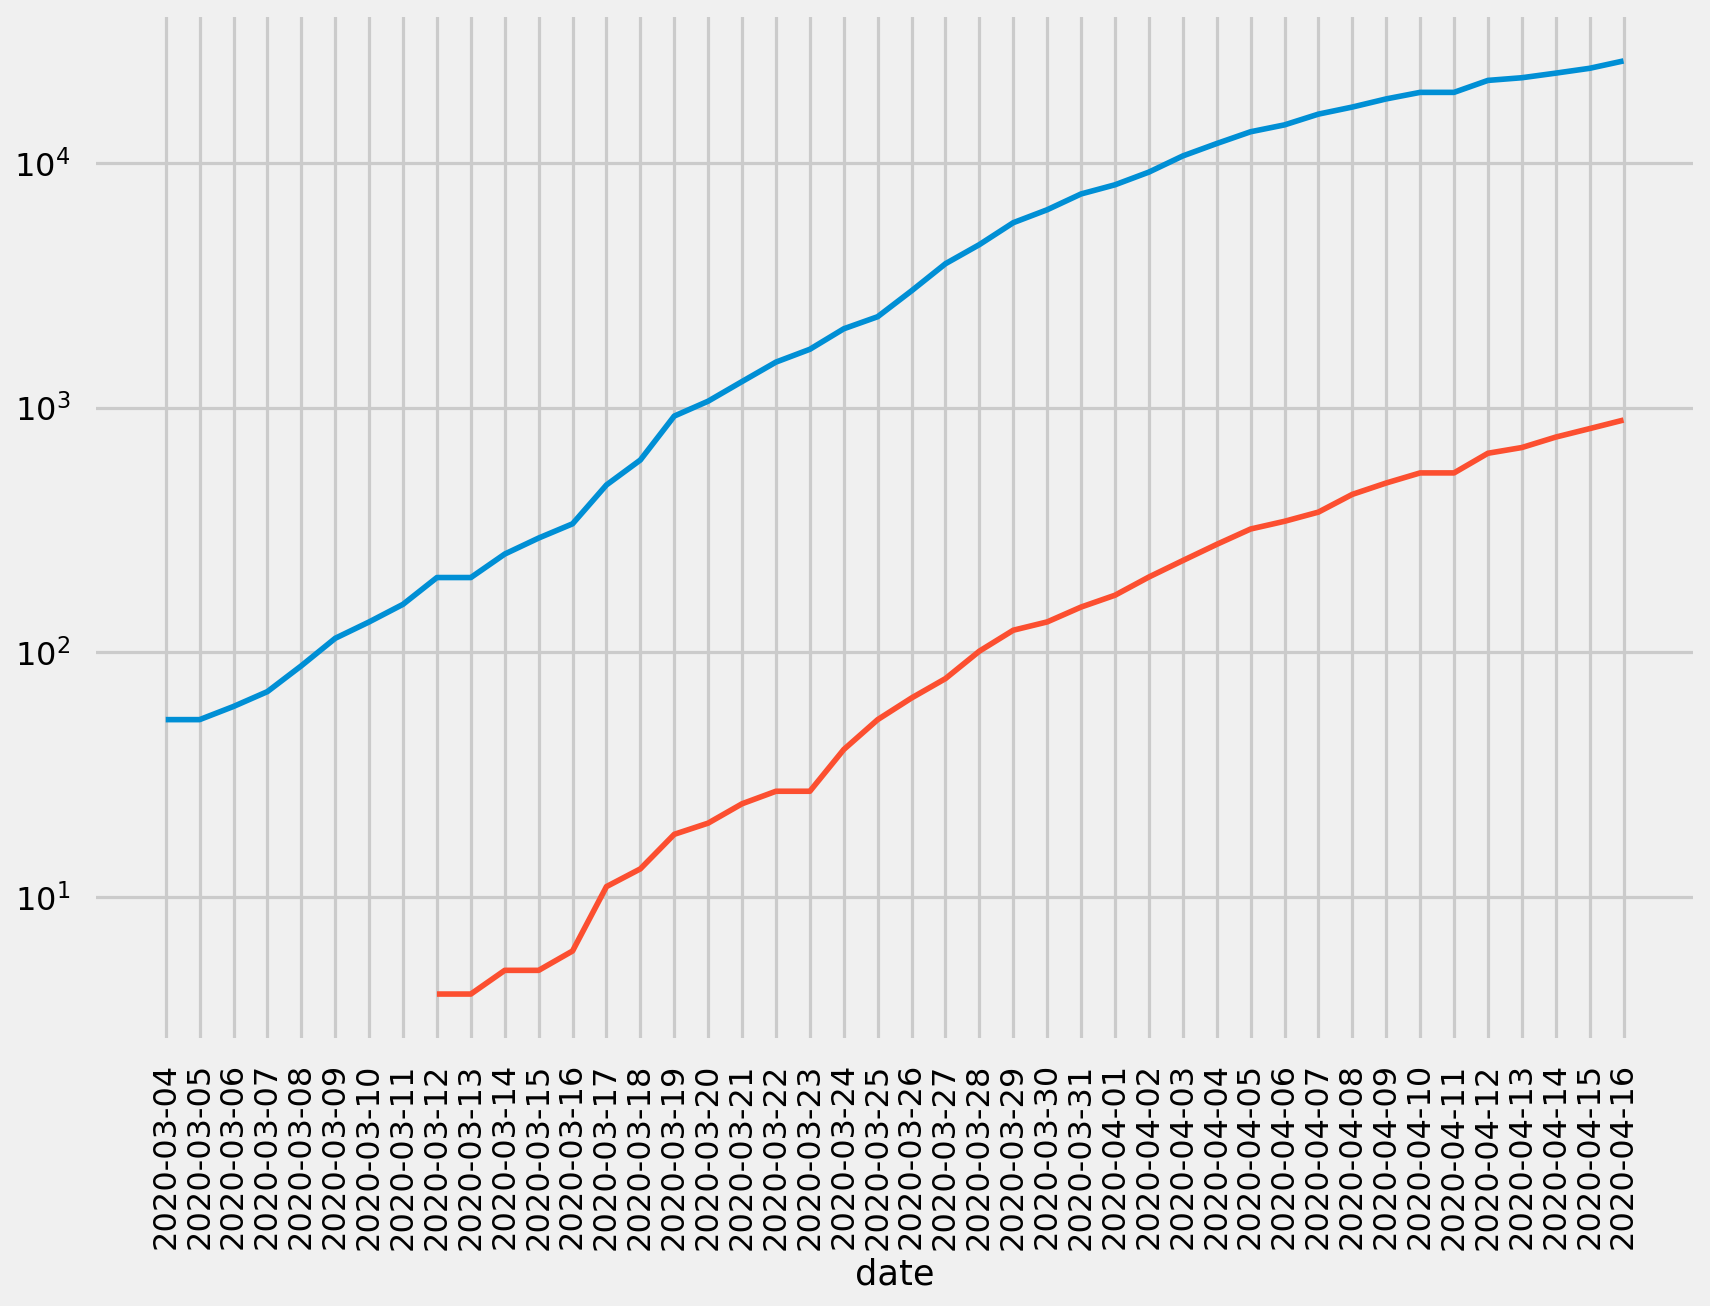

In [14]:
ax = sns.lineplot(x="date", y="positive", 
                  data=df_states.query('state == "CA"'))
ax = sns.lineplot(x="date", y="death", 
                  data=df_states.query('state == "CA"'))
ax.set(xticks=df_states.query('state == "CA"').date.values)
plt.xticks(rotation=90)
ax.set_ylabel('')
ax.set_yscale('log')
plt.show()

## New York

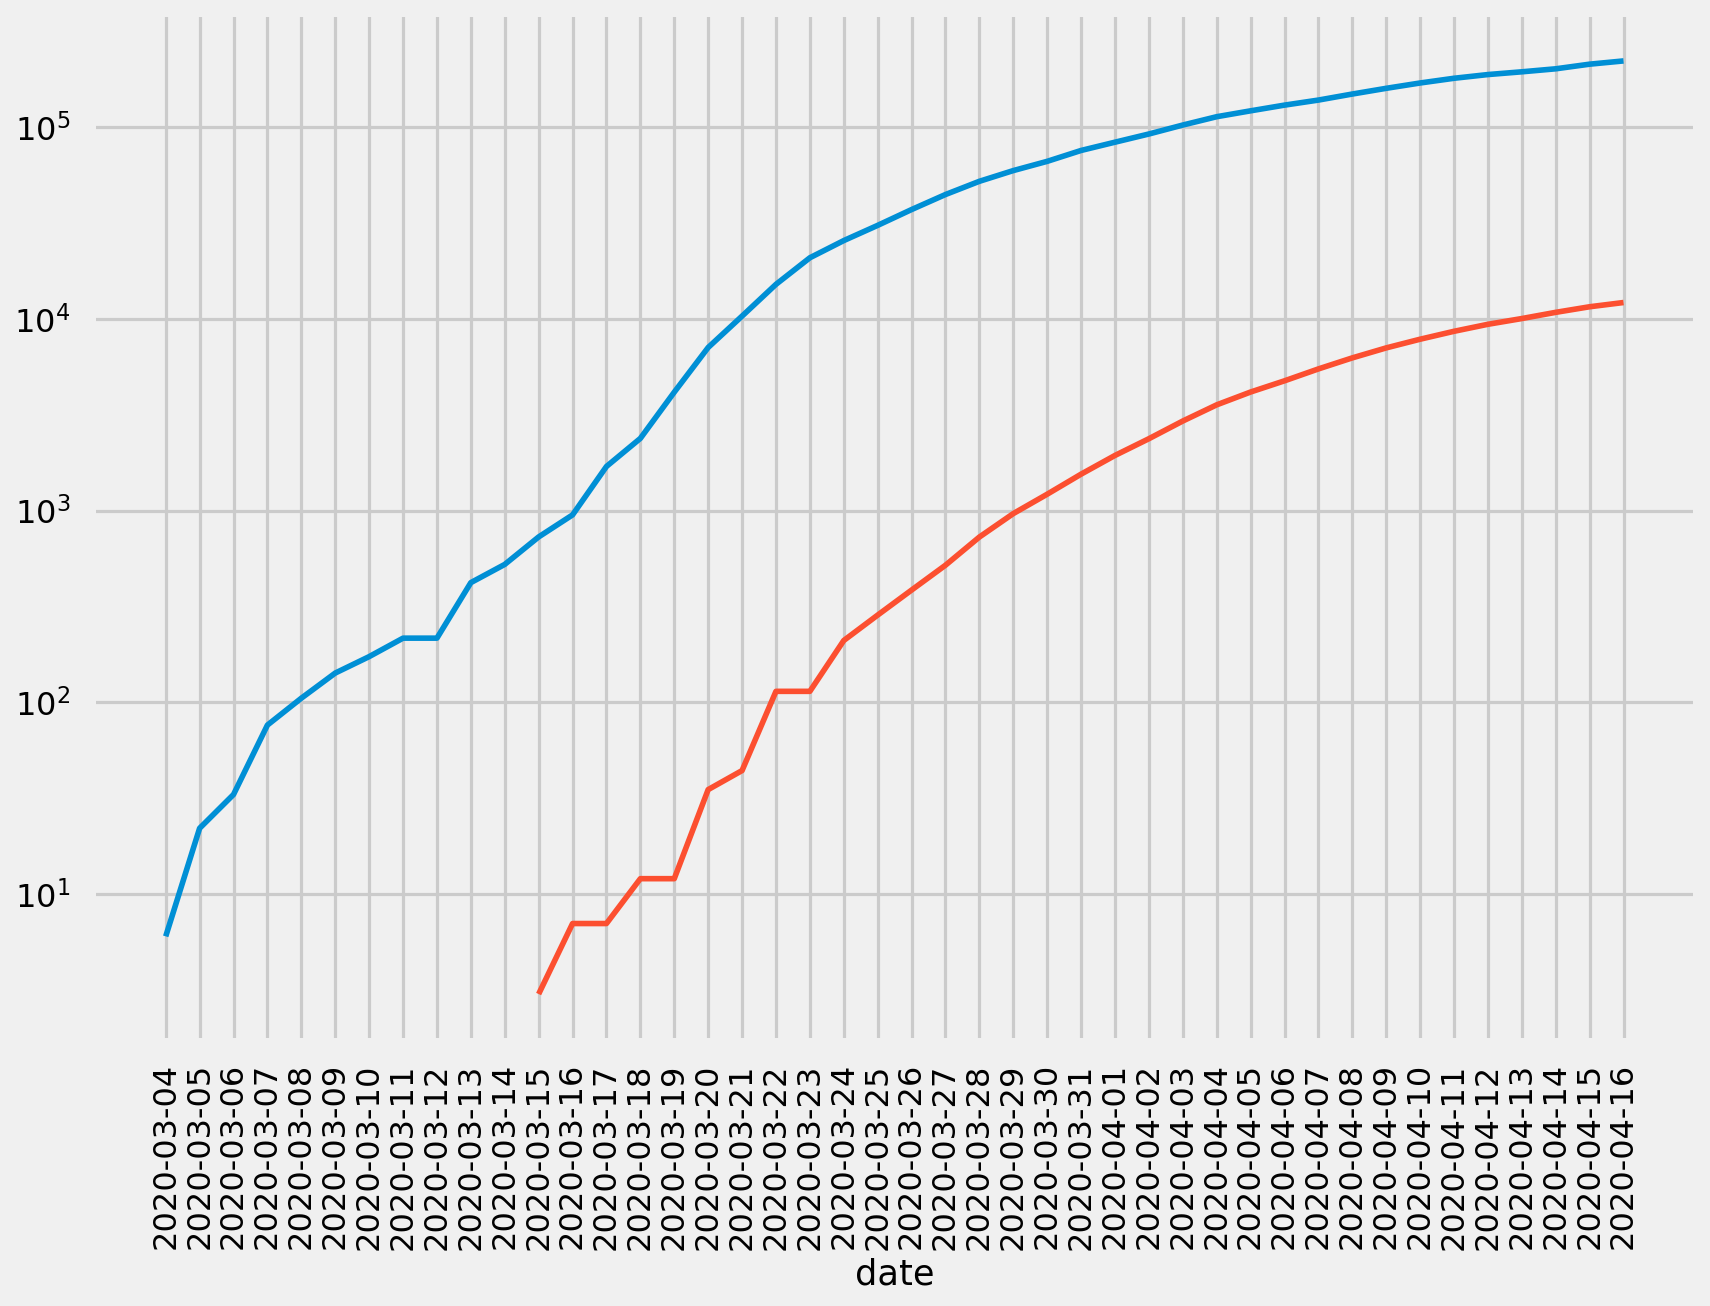

In [15]:
ax = sns.lineplot(x="date", y="positive", 
                  data=df_states.query('state == "NY"'))
ax = sns.lineplot(x="date", y="death", 
                  data=df_states.query('state == "NY"'))
ax.set(xticks=df_states.query('state == "NY"').date.values)
plt.xticks(rotation=90)
ax.set_ylabel('')
ax.set_yscale('log')
plt.show()

# Top 10 States by Deaths

In [16]:
latest_date = df_states['date'].max()
top_states = df_states.query('date == @latest_date').sort_values(by='death', 
                                                    ascending=False).state.head(10).tolist()
df_top_states = df_states.query('state == @top_states')
top_states

['NY', 'NJ', 'MI', 'MA', 'LA', 'IL', 'CT', 'CA', 'PA', 'FL']

In [17]:
df_states.query('date == @latest_date').sort_values(by='death', 
                                                    ascending=False)[['state', 'death']]

,state,death
1445,NY,12192.0
1317,NJ,3518.0
933,MI,2093.0
805,MA,1245.0
764,LA,1156.0
594,IL,1072.0
256,CT,971.0
169,CA,890.0
1617,PA,707.0
382,FL,646.0


In [18]:
# Deaths per 100,000 people
df_states.query('date == @latest_date').sort_values(by='death_rate', 
                                                    ascending=False)[['state', 'death_rate']]

,state,death_rate
1445,NY,62.388034
1317,NJ,39.490286
256,CT,27.178591
764,LA,24.806984
933,MI,20.938553
805,MA,18.037860
297,DC,11.530988
1691,RI,9.930815
594,IL,8.413729
2036,WA,7.524294


# Deaths

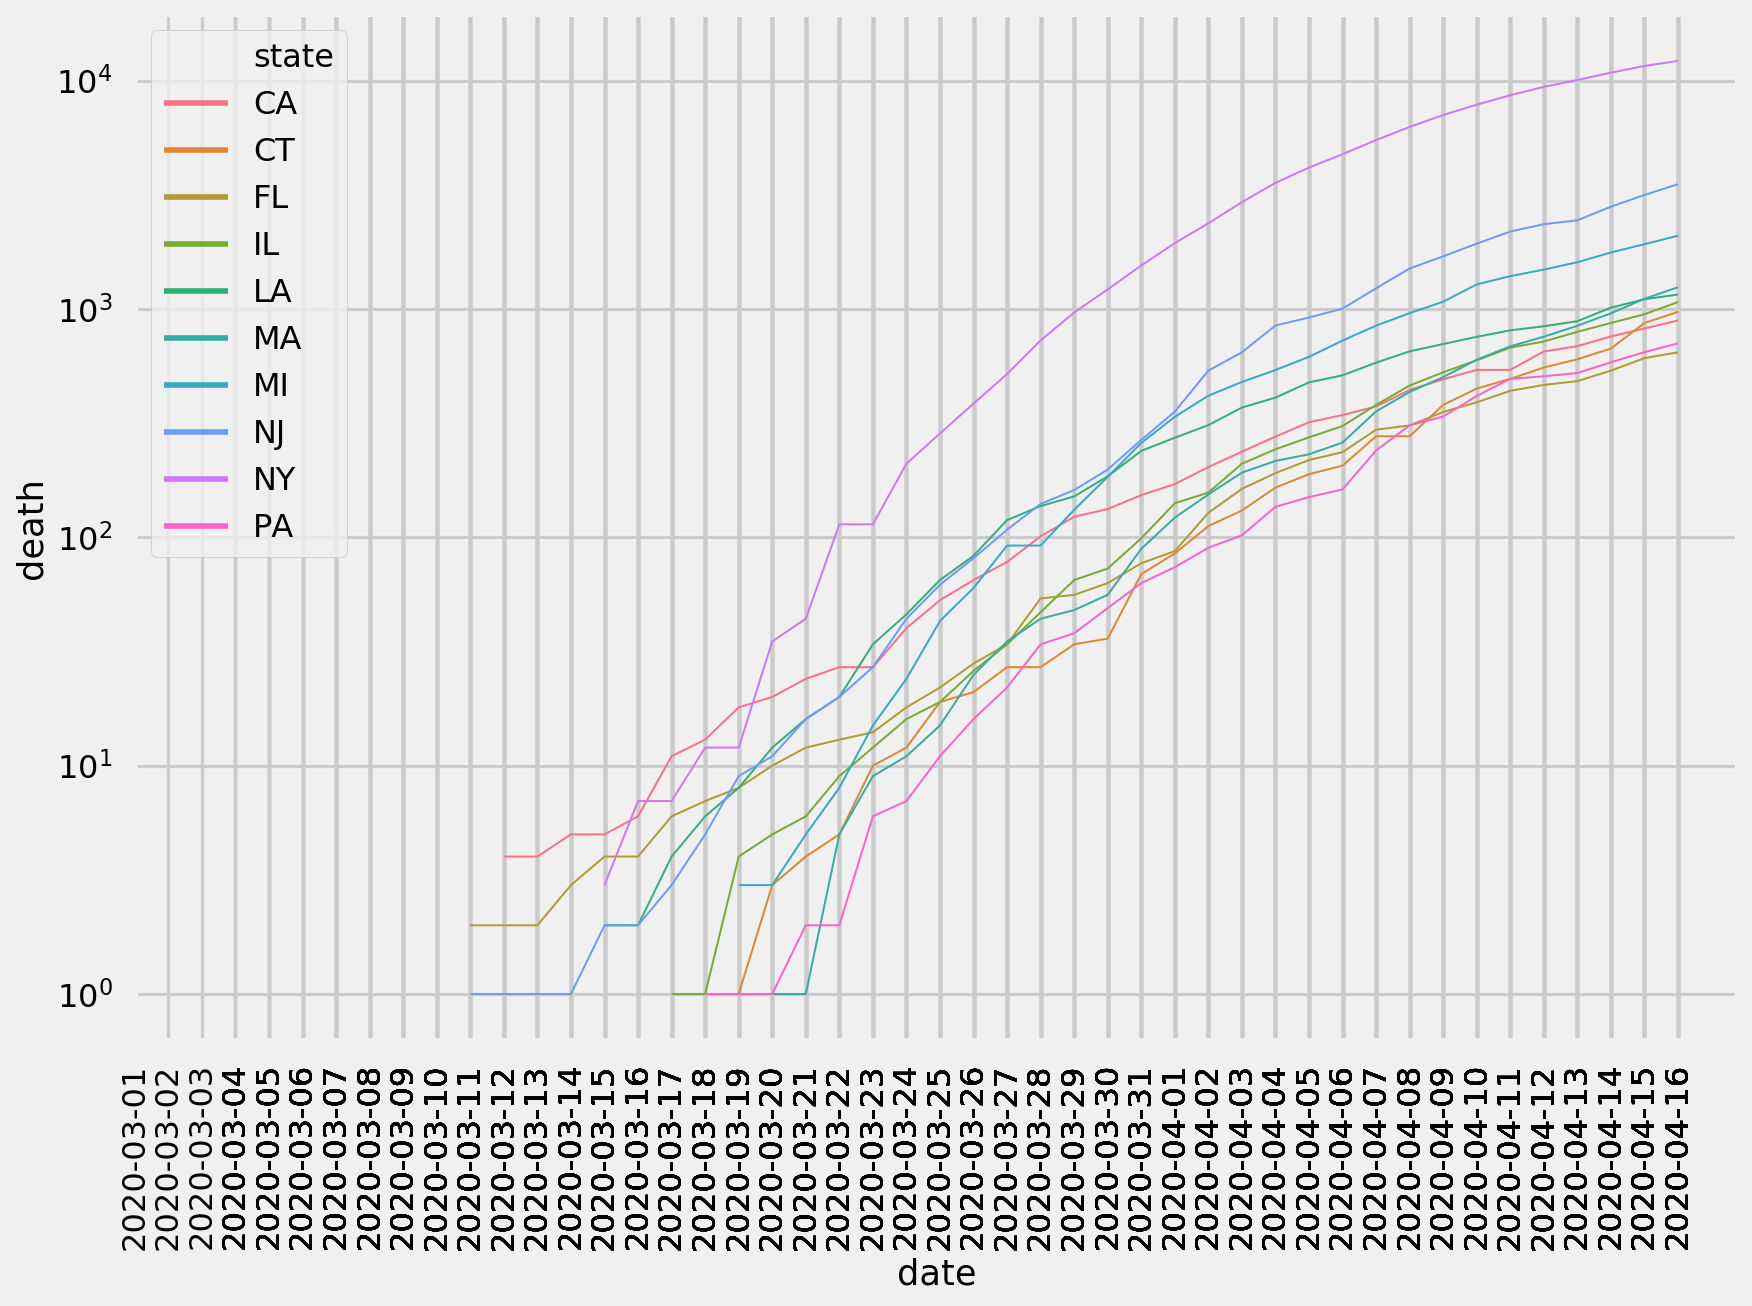

In [19]:
ax = sns.lineplot(x="date", 
                  y="death", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Deaths (7-day Moving Average)

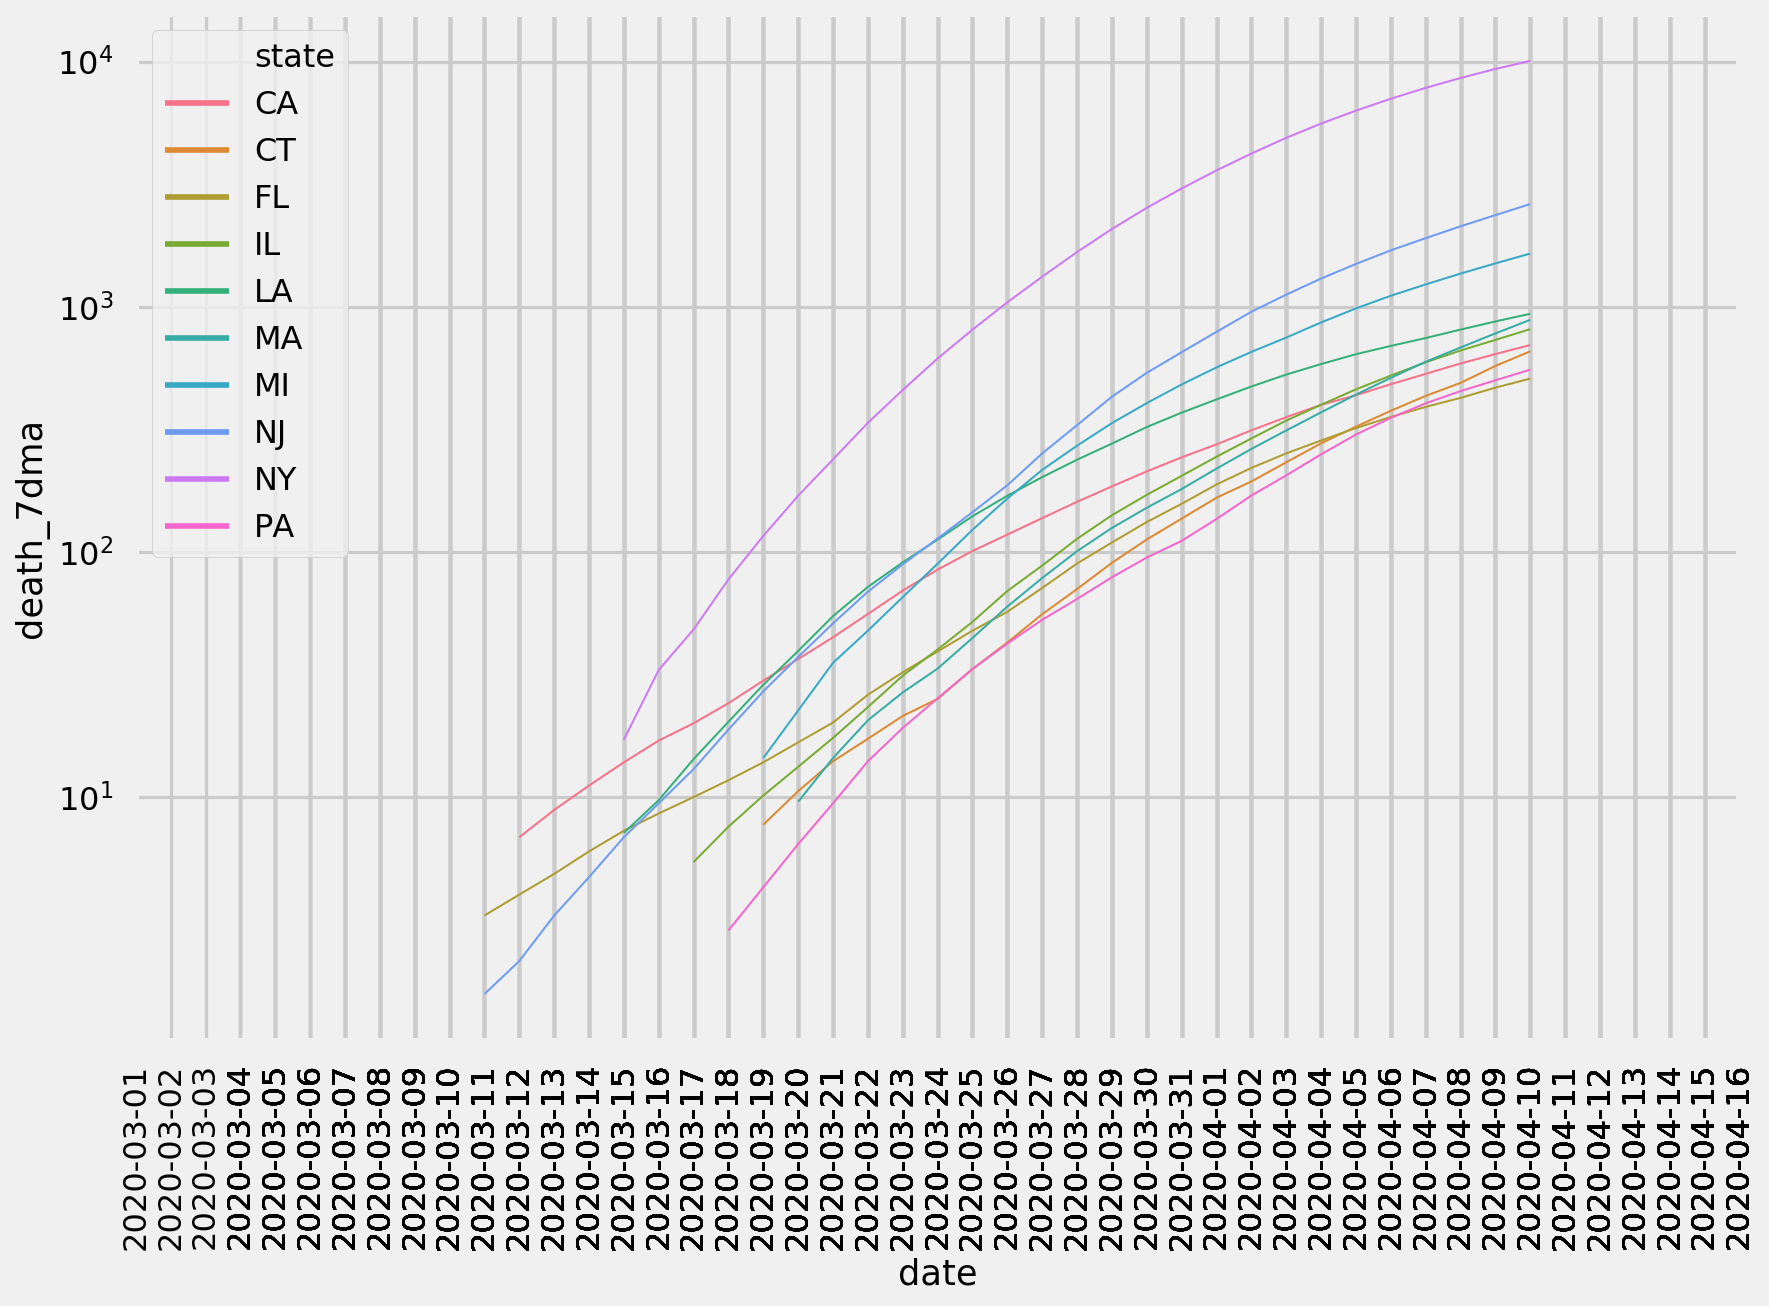

In [20]:
# TODO: index this by date first crossed 5 deaths
ax = sns.lineplot(x="date", 
                  y="death_7dma", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Positive Cases Per 100,000 People

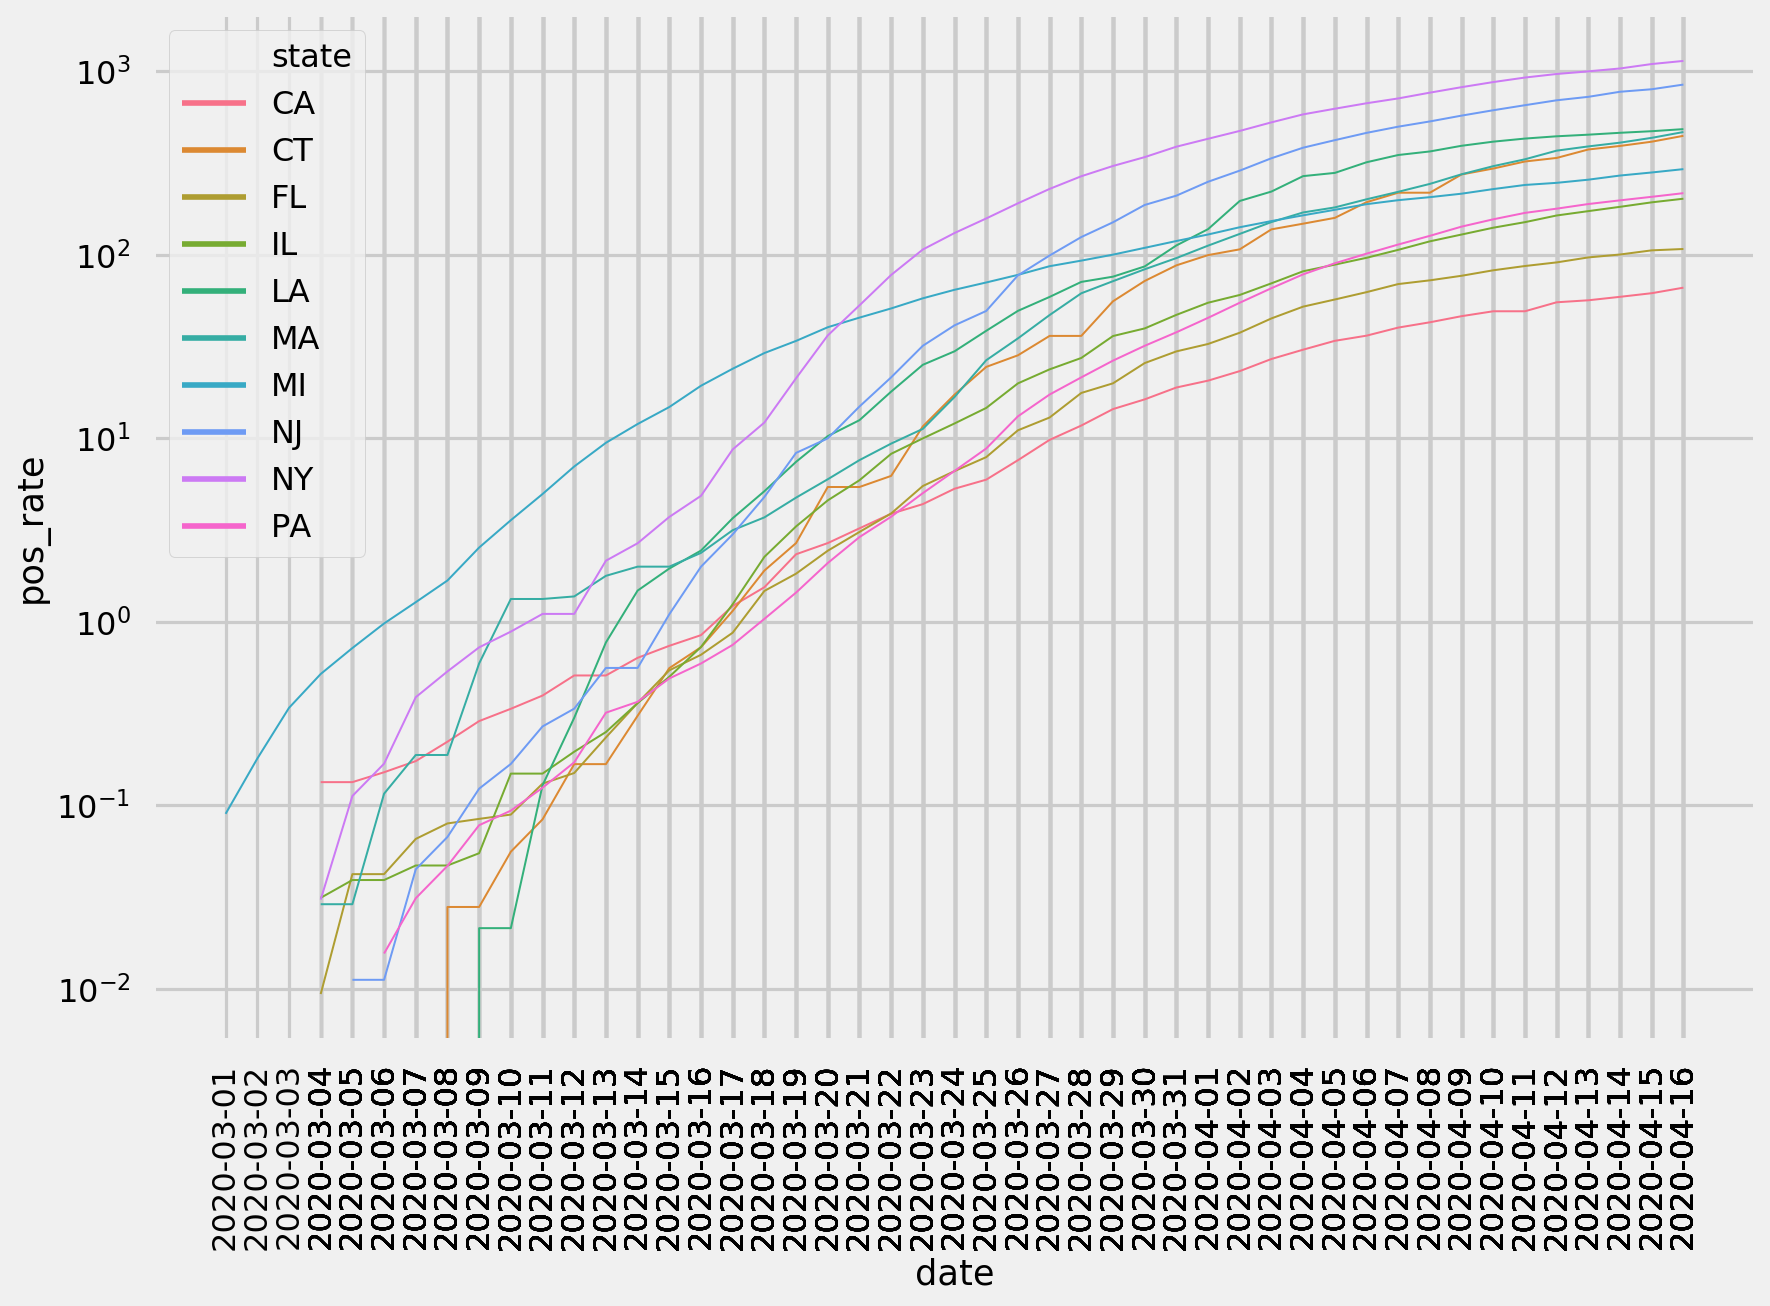

In [21]:
ax = sns.lineplot(x="date", y="pos_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Deaths Per 100,000 People

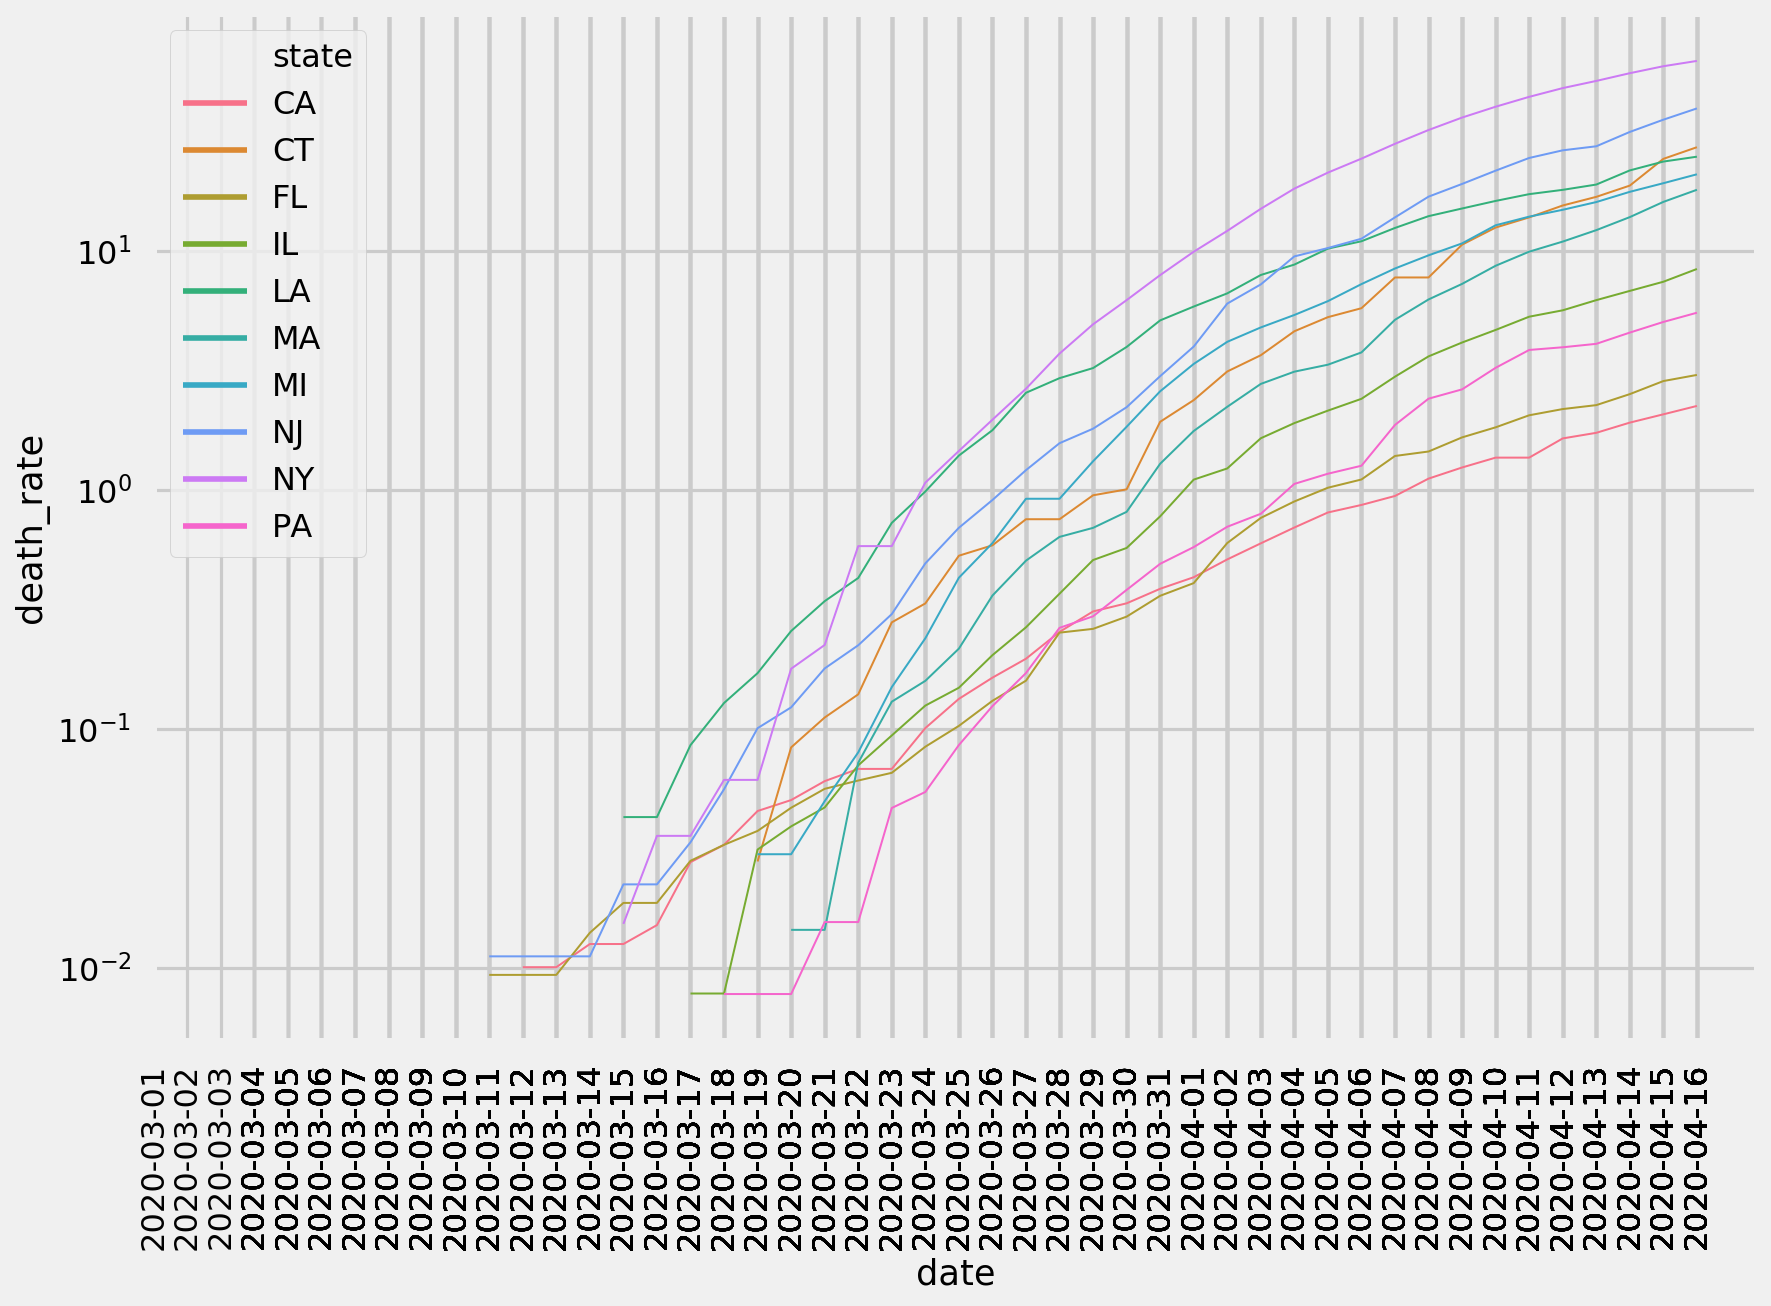

In [22]:
ax = sns.lineplot(x="date", y="death_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Tests Per 100,000 People

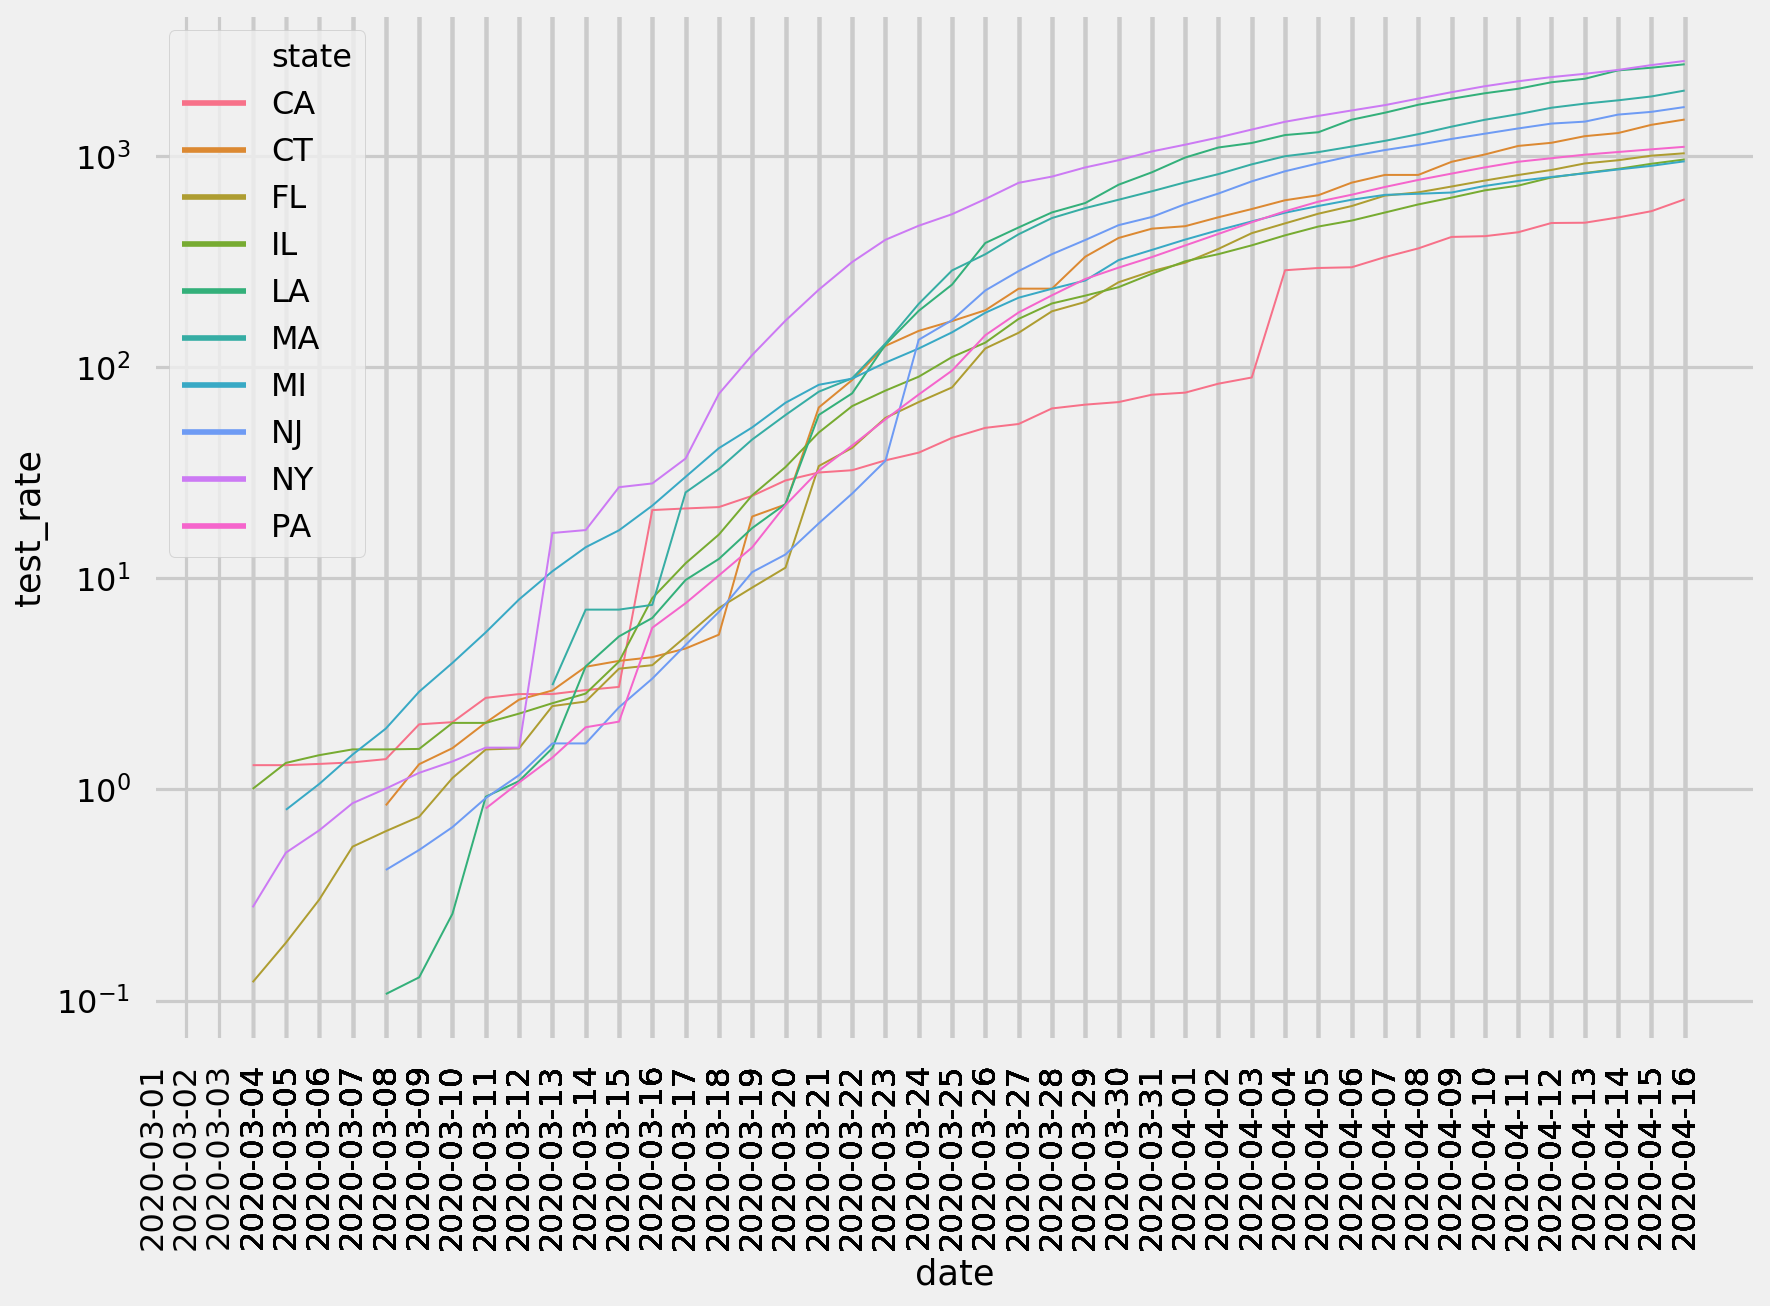

In [23]:
ax = sns.lineplot(x="date", y="test_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

In [24]:
df_states.query('date == @latest_date').sort_values(by='test_rate', 
                                                    ascending=False)[['state', 'test_rate']]

,state,test_rate
1445,NY,2817.383644
764,LA,2716.450593
1691,RI,2654.270487
805,MA,2039.553188
1994,VT,1837.301353
297,DC,1729.648163
1317,NJ,1704.323502
2036,WA,1649.280063
1360,NM,1593.660102
1910,UT,1571.539066
